In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import cm
import matplotlib as mp
import numpy as np
from scipy.ndimage import gaussian_filter

In [116]:
# Asenda path enda omaga
data_path = '/scratch/local/sven/daniel_bsc_thesis_data/star_particles_pos_5e8.npy'
stars = np.load(data_path)

starsdf = pd.DataFrame(stars)
starsdf = starsdf.rename(columns={0:"x", 1:"y", 2:"z"})

starsdf = starsdf[np.abs(starsdf.z) <  20]
print(starsdf.shape)

(44760982, 3)


In [117]:
# 3D rotation matrixes
def rx(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])
def ry(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[ c, 0, s],
                     [ 0, 1, 0],
                     [-s, 0, c]])
def rz(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c,-s, 0],
                     [s, c, 0],
                     [0, 0, 1]])

def rotate(rot_mat, vec):
    return rot_mat @ vec

#-----------------------------------------------------------------------------------------------------------------


Text(0, 0.5, 'y (kpc)')

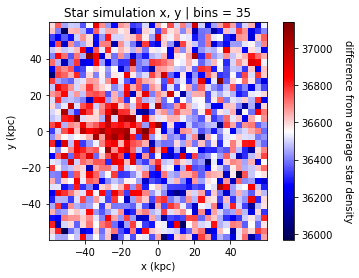

In [118]:
fig, ax = plt.subplots()

OD_hist, xedges, yedges = np.histogram2d(starsdf.x, starsdf.y, (35, 35))
OD_hist[OD_hist == 0] = np.nan  

im = ax.imshow(OD_hist.T, origin='lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = "seismic")
c = plt.colorbar(im, ax=ax)
c.set_label('difference from average star density', rotation=270, labelpad=20)

plt.title('Star simulation x, y | bins = 35')
plt.xlabel( 'x (kpc)')
plt.ylabel('y (kpc)')

Text(0, 0.5, 'y (kpc)')

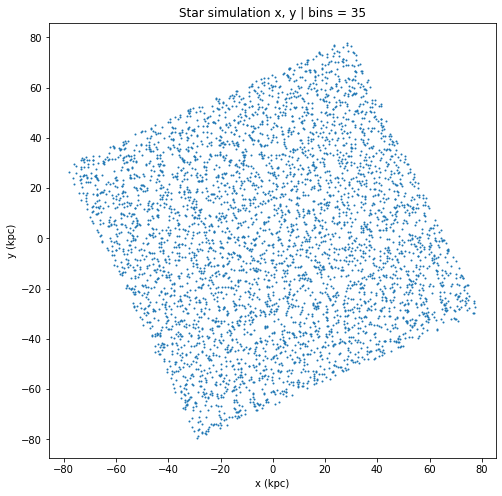

In [119]:
angle = 25
stars_rotated = rotate(rz(np.radians(angle)), np.array(starsdf).T)

fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(stars_rotated[0][::10000], stars_rotated[1][::10000], s=1)

plt.title('Star simulation x, y | bins = 35')
plt.xlabel( 'x (kpc)')
plt.ylabel('y (kpc)')

# Mock wake generation and rotation

In [110]:
# Mock wake generator
def generate_mock_wake(
    
    N_total=300_000,
    box_half_size=300.0,                 # kpc; box is [-L, L]^3
    f_overdense=0.25,                    # fraction of particles in wake component
    mu=(-30.0, 5.0, 0.0),                # kpc; wake center (x0, y0, z0)
    sigma_major=100.0,                    # kpc; wake length-scale along major axis
    sigma_minor=50.0,                    # kpc; width in the orthogonal in-plane axis
    sigma_z=8.0,                         # kpc; thickness
    theta_deg=0.0,                       # rotation of wake in XY plane (deg)
    rng_seed=7
):
    """
    Return a structured ndarray with fields: x,y,z,component (1=wake, 0=bg).
    """
    rng = np.random.default_rng(rng_seed)
    N_over = int(N_total * f_overdense)
    N_bg   = N_total - N_over
    mu = np.asarray(mu, dtype=float)

    # Rotation in the XY plane
    theta = np.deg2rad(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array([[c, -s],
                  [s,  c]])

    # Covariance in XY for the anisotropic Gaussian
    Lambda_xy = np.diag([sigma_major**2, sigma_minor**2])
    Sigma_xy  = R @ Lambda_xy @ R.T

    # Wake samples
    xy_over = rng.multivariate_normal(mean=mu[:2], cov=Sigma_xy, size=N_over)
    z_over  = rng.normal(loc=mu[2], scale=sigma_z, size=N_over)

    # Clip to keep inside box
    xy_over[:, 0] = np.clip(xy_over[:, 0], -box_half_size, box_half_size)
    xy_over[:, 1] = np.clip(xy_over[:, 1], -box_half_size, box_half_size)
    z_over        = np.clip(z_over,        -box_half_size, box_half_size)

    # Uniform background
    x_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    y_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)
    z_bg = rng.uniform(-box_half_size, box_half_size, size=N_bg)

    # Concatenate positions
    x = np.concatenate([xy_over[:, 0], x_bg])
    y = np.concatenate([xy_over[:, 1], y_bg])
    z = np.concatenate([z_over,        z_bg])

    # Pack catalog
    comp = np.concatenate([np.ones(N_over, dtype=np.int8),
                           np.zeros(N_bg, dtype=np.int8)])  # 1=wake, 0=bg
    

    cat = np.zeros(N_total, dtype=[('x','f4'),('y','f4'),('z','f4'),('component','i1')])
    
    cat['x'], cat['y'], cat['z']   = x, y, z
    cat['component'] = comp
    return cat


In [111]:
result = generate_mock_wake()
df = pd.DataFrame(result)
coords = df[['x', 'y', 'z']].values
x_sim = result['x']
y_sim = result['y']
z_sim = result['z']

sim = np.array([x_sim, y_sim, z_sim])

Text(0, 0.5, 'y (kpc)')

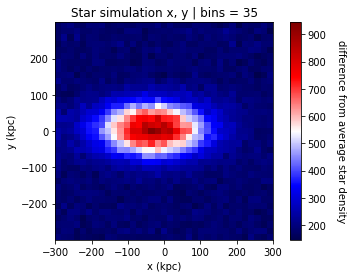

In [112]:
fig, ax = plt.subplots()

OD_hist, xedges, yedges = np.histogram2d(sim[0], sim[1], (35, 35))
OD_hist[OD_hist == 0] = np.nan  

im = ax.imshow(OD_hist.T, origin='lower', extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = "seismic")
c = plt.colorbar(im, ax=ax)
c.set_label('difference from average star density', rotation=270, labelpad=20)

plt.title('Star simulation x, y | bins = 35')
plt.xlabel( 'x (kpc)')
plt.ylabel('y (kpc)')

In [113]:
angle = 25
stars_rotated = rotate(rz(np.radians(angle)), sim)

Text(0, 0.5, 'y (kpc)')

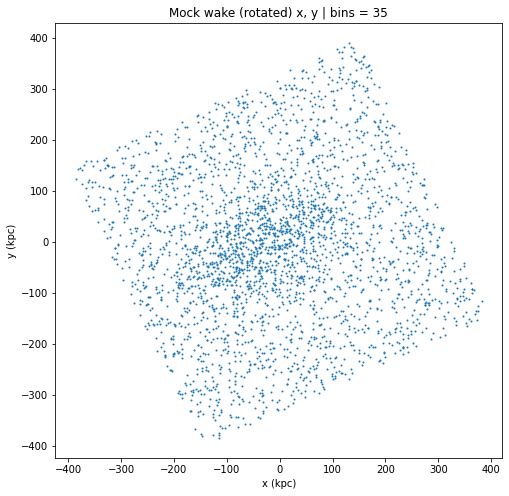

In [114]:
fig, ax = plt.subplots(figsize=(8,8))

plt.scatter(stars_rotated[0][::100], stars_rotated[1][::100], s=1)

plt.title('Mock wake (rotated) x, y | bins = 35')
plt.xlabel( 'x (kpc)')
plt.ylabel('y (kpc)')